#  Web APIs

An API, or aplication programming interface, is the way programs communicate with one another. 

Web APIs are the way programs communicate with one another _over the internet_

[RESTful](https://en.wikipedia.org/wiki/Representational_state_transfer) APIs respect a series of design principles that make them simple to use.

The basic tools we are going to use are: POST and GET requests to urls we'll specify and json objects that we'll receive as response or send as payload (in a POST command, for example).

In [3]:
import requests

resp = requests.get('http://www.elpais.com/')
resp.content[:500]

'<!DOCTYPE html>\n<html lang="es">\n<head>\n<meta charset="utf-8">\n<meta http-equiv="X-UA-Compatible" content="IE=edge">\n<meta name="format-detection" content="address=no,email=no,telephone=no">\n<meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=1.0" />\n<title>EL PA\xc3\x8dS: el peri\xc3\xb3dico global</title>\n<meta name="lang" \t\t\tcontent="es" />\n<meta name="author" \t\tcontent="Ediciones El Pa\xc3\xads" />\n<meta name="description" \tcontent="Noticias de \xc3\xbaltima hora sobre la actualidad '

This is an API that returns the current position of the ISS:

In [21]:
r = requests.get('http://api.open-notify.org/iss-now.json')
r.status_code

200

In [10]:
r.content

'{"timestamp": 1517828358, "message": "success", "iss_position": {"longitude": "64.3077", "latitude": "43.7348"}}'

We can convert a json-formatted string such as the one we get in the response into a Python object with the json library:

In [11]:
import json 

pos = json.loads(r.content)
pos

{u'iss_position': {u'latitude': u'43.7348', u'longitude': u'64.3077'},
 u'message': u'success',
 u'timestamp': 1517828358}

In [12]:
pos['iss_position']['latitude']


u'43.7348'

In [11]:
import pandas as pd

pd.read_json('http://api.open-notify.org/iss-now.json')

,iss_position,message,timestamp
latitude,20.2310,success,2018-02-06 08:59:19
longitude,-157.4087,success,2018-02-06 08:59:19


We also can go in the other direction and generate json-formatted strings from Python objects:

In [14]:
mi_diccionario = {'Chicago' : "Illinois", "Kansas City" : ["Kansas", "Missouri"]}

In [15]:
mi_diccionario

{'Chicago': 'Illinois', 'Kansas City': ['Kansas', 'Missouri']}

In [16]:
json.dumps(mi_diccionario)

'{"Kansas City": ["Kansas", "Missouri"], "Chicago": "Illinois"}'

#### Exercise:
Write a function that returns the duration of the next 5 overhead passes of the ISS for a given latitude and longitude. Use http://open-notify.org/Open-Notify-API/ISS-Pass-Times/
. We are going to need to encode the parameters in the url as per the specification.

For example, for Madrid:

http://api.open-notify.org/iss-pass.json?lat=40.4&lon=-3.7

In [22]:
def get_iss(lat, lon):
    
    url = "http://api.open-notify.org/iss-pass.json?lat=%f&lon=%f" % (lat, lon)
    response = requests.get(url)
    my_dict = json.loads(response.content)
    result = my_dict['response']
    
    return result

get_iss(40.4, -3.7)

{u'message': u'success',
 u'request': {u'altitude': 100,
  u'datetime': 1517828723,
  u'latitude': 40.4,
  u'longitude': -3.7,
  u'passes': 5},
 u'response': [{u'duration': 594, u'risetime': 1517838947},
  {u'duration': 630, u'risetime': 1517844709},
  {u'duration': 556, u'risetime': 1517850576},
  {u'duration': 551, u'risetime': 1517856432},
  {u'duration': 626, u'risetime': 1517862228}]}

Although we managed to get the response, more complicated sets of parameters will be a complicated and error-prone thing to encode. Thankfully, the `requests` library can do that work for us.

In [11]:
madrid_coords = {'lat': 40.4, 'lon': -3.7}

r = requests.get('http://api.open-notify.org/iss-pass.json', params=madrid_coords)
json.loads(r.content)

{u'message': u'success',
 u'request': {u'altitude': 100,
  u'datetime': 1493986734,
  u'latitude': 40.4,
  u'longitude': -3.7,
  u'passes': 5},
 u'response': [{u'duration': 371, u'risetime': 1493989991},
  {u'duration': 417, u'risetime': 1494038436},
  {u'duration': 637, u'risetime': 1494044076},
  {u'duration': 601, u'risetime': 1494049897},
  {u'duration': 537, u'risetime': 1494055774}]}

In [12]:
resp = json.loads(r.content)['response']

pd.DataFrame(resp)

,duration,risetime
0,371,1493989991
1,417,1494038436
2,637,1494044076
3,601,1494049897
4,537,1494055774


Even more complicated sets of parameters are sometimes required. When that is the case, API designers often decide to require them in json format, received via a `POST` request.

For example, take a look at the [QPX api from Google](https://developers.google.com/qpx-express/v1/trips/search). In the documentation, they define the body of the request, which we will have to provide, and of the response, which they'll provide back.

In [13]:
help(requests.post)

Help on function post in module requests.api:

post(url, data=None, json=None, **kwargs)
    Sends a POST request.
    
    :param url: URL for the new :class:`Request` object.
    :param data: (optional) Dictionary, bytes, or file-like object to send in the body of the :class:`Request`.
    :param json: (optional) json data to send in the body of the :class:`Request`.
    :param \*\*kwargs: Optional arguments that ``request`` takes.
    :return: :class:`Response <Response>` object
    :rtype: requests.Response



# Web scraping

![HTML to DOM](http://www.cs.toronto.edu/~shiva/cscb07/img/dom/treeStructure.png)

![DOM TREE](http://www.openbookproject.net/tutorials/getdown/css/images/lesson4/HTMLDOMTree.png)



In [8]:
from IPython.display import IFrame

IFrame('http://www.aflcio.org/Legislation-and-Politics/Legislative-Alerts', 800, 600)

In [41]:
from bs4 import BeautifulSoup

r = requests.get('http://www.aflcio.org/Legislation-and-Politics/Legislative-Alerts')

page = r.content
page[:1000]

'<!DOCTYPE html>\n<html lang="en" dir="ltr" xmlns:article="http://ogp.me/ns/article#" xmlns:book="http://ogp.me/ns/book#" xmlns:product="http://ogp.me/ns/product#" xmlns:profile="http://ogp.me/ns/profile#" xmlns:video="http://ogp.me/ns/video#" prefix="content: http://purl.org/rss/1.0/modules/content/  dc: http://purl.org/dc/terms/  foaf: http://xmlns.com/foaf/0.1/  og: http://ogp.me/ns#  rdfs: http://www.w3.org/2000/01/rdf-schema#  schema: http://schema.org/  sioc: http://rdfs.org/sioc/ns#  sioct: http://rdfs.org/sioc/types#  skos: http://www.w3.org/2004/02/skos/core#  xsd: http://www.w3.org/2001/XMLSchema# ">\n  <head>\n    <meta charset="utf-8" /><script type="text/javascript">window.NREUM||(NREUM={}),__nr_require=function(e,t,n){function r(n){if(!t[n]){var o=t[n]={exports:{}};e[n][0].call(o.exports,function(t){var o=e[n][1][t];return r(o||t)},o,o.exports)}return t[n].exports}if("function"==typeof __nr_require)return __nr_require;for(var o=0;o<n.length;o++)r(n[o]);return r}({1:[funct

In [42]:
soup = BeautifulSoup(page, 'html5lib')
print soup.prettify()[:1000]

<!DOCTYPE html>
<html dir="ltr" lang="en" prefix="content: http://purl.org/rss/1.0/modules/content/  dc: http://purl.org/dc/terms/  foaf: http://xmlns.com/foaf/0.1/  og: http://ogp.me/ns#  rdfs: http://www.w3.org/2000/01/rdf-schema#  schema: http://schema.org/  sioc: http://rdfs.org/sioc/ns#  sioct: http://rdfs.org/sioc/types#  skos: http://www.w3.org/2004/02/skos/core#  xsd: http://www.w3.org/2001/XMLSchema# " xmlns:article="http://ogp.me/ns/article#" xmlns:book="http://ogp.me/ns/book#" xmlns:product="http://ogp.me/ns/product#" xmlns:profile="http://ogp.me/ns/profile#" xmlns:video="http://ogp.me/ns/video#">
 <head>
  <meta charset="utf-8"/>
  <script type="text/javascript">
   window.NREUM||(NREUM={}),__nr_require=function(e,t,n){function r(n){if(!t[n]){var o=t[n]={exports:{}};e[n][0].call(o.exports,function(t){var o=e[n][1][t];return r(o||t)},o,o.exports)}return t[n].exports}if("function"==typeof __nr_require)return __nr_require;for(var o=0;o<n.length;o++)r(n[o]);return r}({1:[functi

In [43]:
print soup.prettify()[28700:30500]

class="content-title">
                  <span>
                   Letter Opposing Legislation That Would Advance Flawed Immigration Enforcement Methods
                  </span>
                 </h2>
                 <time datetime="2017-10-31T10:48:37-0400">
                  October 31, 2017
                 </time>
                </div>
               </a>
               <div>
               </div>
              </div>
             </div>
             <div class="block block-content col-12 col-lg-4">
              <div class="content-details ">
               <a class="b-inner" href="/about/advocacy/legislative-alerts/letter-opposing-bill-would-weaken-protections-us-workers-and-make">
                <div class="b-text">
                 <h5 class="content-type">
                  Legislative Alert
                 </h5>
                 <h2 class="content-title">
                  <span>
                   Letter Opposing Bill That Would Weaken Protections for U.S. Workers and M

In [44]:
help(soup.find_all)

Help on method find_all in module bs4.element:

find_all(self, name=None, attrs={}, recursive=True, text=None, limit=None, **kwargs) method of bs4.BeautifulSoup instance
    Extracts a list of Tag objects that match the given
    criteria.  You can specify the name of the Tag and any
    attributes you want the Tag to have.
    
    The value of a key-value pair in the 'attrs' map can be a
    string, a list of strings, a regular expression object, or a
    callable that takes a string and returns whether or not the
    string matches for some custom definition of 'matches'. The
    same is true of the tag name.



In [45]:
alerts = soup.find_all('div', class_='content-details')
print len(alerts)
type(alerts)

18


bs4.element.ResultSet

In [51]:
alerts[0]

<div class="content-details ">\n\t<a class="b-inner" href="/about/advocacy/legislative-alerts/letter-representatives-opposing-act-would-deny-protections">\n\t  <div class="b-text">\n      <h5 class="content-type">Legislative Alert</h5>\n      <h2 class="content-title"><span>Letter to Representatives Opposing an Act That Would Deny Protections for Workers Employed on Indian Land</span>\n</h2>\n            <time datetime="2018-01-09T14:40:19-0500">January 9, 2018</time>\n    </div>\n\t</a>\n  <div></div>\n</div>

In [49]:
first = alerts[0]
print first.find('time').get_text()
print first.a.find('span').get_text()
print first.a['href']

January 9, 2018
Letter to Representatives Opposing an Act That Would Deny Protections for Workers Employed on Indian Land
/about/advocacy/legislative-alerts/letter-representatives-opposing-act-would-deny-protections


In [52]:
def get_aflcio_alerts():
    result = []
    r = requests.get('http://www.aflcio.org/Legislation-and-Politics/Legislative-Alerts')
    soup = BeautifulSoup(r.content, 'html5lib')
    
    for alert in soup.find_all('div', class_='content-details'):
        dictionary = {}
        dictionary['date'] = alert.find('time').get_text()
        dictionary['title'] = alert.a.find('span').get_text()
        dictionary['link'] = 'http://www.aflcio.org' + alert.a['href']
        
        result.append(dictionary)
        
    return result

In [53]:
letters = get_aflcio_alerts()
letters[:2]

[{'date': u'January 9, 2018',
  'link': u'http://www.aflcio.org/about/advocacy/legislative-alerts/letter-representatives-opposing-act-would-deny-protections',
  'title': u'Letter to Representatives Opposing an Act That Would Deny Protections for Workers Employed on Indian Land'},
 {'date': u'December 19, 2017',
  'link': u'http://www.aflcio.org/about/advocacy/legislative-alerts/letter-opposing-tax-legislation-will-kill-jobs-and-give-huge-tax',
  'title': u'Letter Opposing Tax Legislation That Will Kill Jobs and Give Huge Tax Breaks to Corporations'}]

In [54]:
# And we come full circle! We encode the list we created in 
# a json string. We could then provide that over the internet
# in our own API!!

json.dumps(letters)[:1000]

'[{"date": "January 9, 2018", "link": "http://www.aflcio.org/about/advocacy/legislative-alerts/letter-representatives-opposing-act-would-deny-protections", "title": "Letter to Representatives Opposing an Act That Would Deny Protections for Workers Employed on Indian Land"}, {"date": "December 19, 2017", "link": "http://www.aflcio.org/about/advocacy/legislative-alerts/letter-opposing-tax-legislation-will-kill-jobs-and-give-huge-tax", "title": "Letter Opposing Tax Legislation That Will Kill Jobs and Give Huge Tax Breaks to Corporations"}, {"date": "November 28, 2017", "link": "http://www.aflcio.org/about/advocacy/legislative-alerts/opposition-nomination-alex-azar-be-secretary-department-health", "title": "In Opposition to the Nomination of Alex Azar to be Secretary of the Department of Health and Human Services"}, {"date": "November 3, 2017", "link": "http://www.aflcio.org/about/advocacy/legislative-alerts/letter-opposing-bill-would-slash-support-health-programs-benefit", "title": "Lette

# Annex: ultra easy scraping with pandas!

When the data we want is already formatted as a table, we can do it even more easily! Just use `pandas.read_html`:

In [24]:
tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_accidents_and_disasters_by_death_toll', header=0)

In [31]:
tables[4].head()

,Deaths,Date,Incident
0,20000,000000001626-05-30-000030 May 1626,"Wanggongchang Explosion in Beijing, China in t..."
1,6000,000000001948-11-01-00001 November 1948,Boiler and ammunition explosion aboard an unid...
2,3000,000000001769-08-18-000018 August 1769,A lightning bolt caused the Brescia Explosion ...
3,1950,000000001917-12-06-00006 December 1917,"Halifax Explosion in Nova Scotia, Canada[43]"
4,1500,000000001941-06-08-00008 June 1941,Ammunition plant with facilities explode at Sm...


# Annex II: exercises

### Exercise:

Extract the date of the worst aviation disaster from: https://en.wikipedia.org/wiki/List_of_accidents_and_disasters_by_death_toll

Prerequisites: pandas, pd.read_html

In [29]:
import pandas as pd
disaster_tables = pd.read_html("https://en.wikipedia.org/wiki/List_of_accidents_and_disasters_by_death_toll", header = 0)

In [30]:
aviation = disaster_tables[2] # reading from html
aviation.head()

,Deaths,Date,Incident,Location
0,583,27 March 1977,Pan Am Flight 1736 and KLM Flight 4805,"Tenerife, Canary Islands, Spain"
1,520,12 August 1985,Japan Airlines Flight 123,"Ueno, Japan"
2,349,12 November 1996,Saudi Arabian Flight 763 and Kazakhstan Airlin...,"Charkhi Dadri, Haryana, India"
3,346,3 March 1974,Turkish Airlines Flight 981,"Fontaine-Chaalis, France"
4,301,19 August 1980,Saudia Flight 163,"Riyadh, Saudi Arabia"


In [31]:
aviation.sort_values('Deaths', ascending = False).head(1)['Date']

0    27 March 1977
Name: Date, dtype: object

### Exercise: 

Assuming the list is exhaustive, calculate how many people died in accidental explosions per decade in the XX century. Plot it.

Data: 
https://en.wikipedia.org/wiki/List_of_accidents_and_disasters_by_death_toll

Prerequisites: pandas, pd.read_html, pd.to_datetime, matplotlib or seaborn

In [165]:
import numpy as np
disaster_tables = pd.read_html("https://en.wikipedia.org/wiki/List_of_accidents_and_disasters_by_death_toll", header = 0)
explotions = disaster_tables[4] # reading from html

In [166]:
explotions.head()

,Deaths,Date,Incident
0,20000,000000001626-05-30-000030 May 1626,"Wanggongchang Explosion in Beijing, China in t..."
1,6000,000000001948-11-01-00001 November 1948,Boiler and ammunition explosion aboard an unid...
2,3000,000000001769-08-18-000018 August 1769,A lightning bolt caused the Brescia Explosion ...
3,1950,000000001917-12-06-00006 December 1917,"Halifax Explosion in Nova Scotia, Canada[43]"
4,1500,000000001941-06-08-00008 June 1941,Ammunition plant with facilities explode at Sm...


In [167]:
def stringDate_to_decade(string):
    decade = int(string[-4:-1]+"0")
    return decade

stringDate_to_decade(explotions['Date'][0])

1620

Parsing dates from _explotions_ dataframe to decade:

In [168]:
explotions['decade'] = explotions['Date'].map(stringDate_to_decade)

There are some extra white spaces, symbols and other things like "[a]", +, etc. Let's convert the Deaths variable into integer.

In [169]:
def get_num(x):
    return int(''.join(ele for ele in x if ele.isdigit()))

print(get_num("2,000"))
print(get_num("100+"))
print(get_num("63[a]"))

2000
100
63


In [170]:
explotions['Deaths'] = explotions['Deaths'].map(lambda x:get_num(x))

Grouping by decade and aggregate the number of deaths for each decade.

In [171]:
deaths_by_decade = pd.DataFrame(explotions.groupby('decade')['Deaths'].sum())

Selecting XX century...

In [177]:
mask_XX_century = (deaths_by_decade.reset_index()['decade'] >= 1900) & (deaths_by_decade.reset_index()['decade'] <= 2000)

In [191]:
deaths_XX_century = deaths_by_decade.reset_index()[mask_XX_century]
deaths_XX_century.set_index('decade')

,Deaths
decade,
1900,1247
1910,6065
1920,2866
1930,1001
1940,14366
1950,1650
1960,477
1970,848
1980,2971


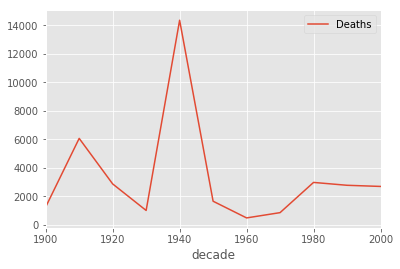

In [192]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

deaths_XX_century.set_index('decade').plot()

### Exercise: 

create a function that, given the two tables extracted from http://en.wikipedia.org/wiki/List_of_S%26P_500_companies and a date, returns the list of companies in the S&P 500 at that date.

There is no problem for reading the first table from wikipedia, since each value in the table corresponds to one cell.

In [ ]:
sp_companies = pd.read_html("http://en.wikipedia.org/wiki/List_of_S%26P_500_companies", header = 0)

In [15]:
stocks = sp_companies[0]
stocks.head()

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152
3,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373
4,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877


However, for the second html table we have some problems in certain rows because of combined cells.

In [41]:
changes = sp_companies[1]
changes.iloc[7:12]

,Unnamed: 0,Added,Removed,Unnamed: 3,Unnamed: 4,Unnamed: 5
7,"August 7, 2017",BHF,Brighthouse Financial Inc,NaN,NaN,MET spun off BHF[13]
8,"July 26, 2017",DRE,Duke Realty Corp,RIG,Transocean,Market capitalization changes.[14]
9,AOS,A.O. Smith,BBBY,Bed Bath & Beyond,NaN,NaN
10,PKG,Packaging Corporation of America,MUR,Murphy Oil,NaN,NaN
11,RMD,ResMed,MNK,Mallinckrodt,NaN,NaN


For solving this problem we are going to use some code writed by _John Ricco_ in his blog (https://johnricco.github.io/2017/04/04/python-html/) in order to get the table in the proper format:

In [37]:
import os
import requests
import urllib
import math
import copy
import pandas as pd	
import numpy as np
from bs4 import BeautifulSoup 

class html_tables(object):
    
    def __init__(self, url):
        
        self.url      = url
        self.r        = requests.get(self.url)
        self.url_soup = BeautifulSoup(self.r.text)
        
    def read(self):
        
        self.tables      = []
        self.tables_html = self.url_soup.find_all("table")
        
        # Parse each table
        for n in range(0, len(self.tables_html)):
            
            n_cols = 0
            n_rows = 0
            
            for row in self.tables_html[n].find_all("tr"):
                col_tags = row.find_all(["td", "th"])
                if len(col_tags) > 0:
                    n_rows += 1
                    if len(col_tags) > n_cols:
                        n_cols = len(col_tags)
            
            # Create dataframe
            df = pd.DataFrame(index = range(0, n_rows), columns = range(0, n_cols))
            
            # Create list to store rowspan values 
            skip_index = [0 for i in range(0, n_cols)]

            # Start by iterating over each row in this table...
            row_counter = 0
            for row in self.tables_html[n].find_all("tr"):
                
                # Skip row if it's blank
                if len(row.find_all(["td", "th"])) == 0:
                    next
                
                else:
                    
                    # Get all cells containing data in this row
                    columns = row.find_all(["td", "th"])
                    col_dim = []
                    row_dim = []
                    col_dim_counter = -1
                    row_dim_counter = -1
                    col_counter = -1
                    this_skip_index = copy.deepcopy(skip_index)
                    
                    for col in columns:
                        
                        # Determine cell dimensions
                        colspan = col.get("colspan")
                        if colspan is None:
                            col_dim.append(1)
                        else:
                            col_dim.append(int(colspan))
                        col_dim_counter += 1
                            
                        rowspan = col.get("rowspan")
                        if rowspan is None:
                            row_dim.append(1)
                        else:
                            row_dim.append(int(rowspan))
                        row_dim_counter += 1
                            
                        # Adjust column counter
                        if col_counter == -1:
                            col_counter = 0  
                        else:
                            col_counter = col_counter + col_dim[col_dim_counter - 1]
                            
                        while skip_index[col_counter] > 0:
                            col_counter += 1

                        # Get cell contents  
                        cell_data = col.get_text()
                        
                        # Insert data into cell
                        df.iat[row_counter, col_counter] = cell_data

                        # Record column skipping index
                        if row_dim[row_dim_counter] > 1:
                            this_skip_index[col_counter] = row_dim[row_dim_counter]
                
                # Adjust row counter 
                row_counter += 1
                
                # Adjust column skipping index
                skip_index = [i - 1 if i > 0 else i for i in this_skip_index]

            # Append dataframe to list of tables
            self.tables.append(df)
        
        return(self.tables)

In [46]:
changes = html_tables("http://en.wikipedia.org/wiki/List_of_S%26P_500_companies").read()[1]
changes.columns = ['date', 'ticker_add', 'security_add', 'ticker_rem', 'security_rem', 'reason']
changes = changes.iloc[2:]
changes.iloc[6:10]

,date,ticker_add,security_add,ticker_rem,security_rem,reason
8,"August 7, 2017",BHF,Brighthouse Financial Inc,,,MET spun off BHF[13]
9,"July 26, 2017",DRE,Duke Realty Corp,RIG,Transocean,Market capitalization changes.[14]
10,NaN,AOS,A.O. Smith,BBBY,Bed Bath & Beyond,NaN
11,NaN,PKG,Packaging Corporation of America,MUR,Murphy Oil,NaN


Now, it looks better although there are some missing values in the date column. Let's fill them with the previous date.

In [49]:
changes['date'] = changes['date'].fillna(method = "ffill")
changes.iloc[6:10]

,date,ticker_add,security_add,ticker_rem,security_rem,reason
8,"August 7, 2017",BHF,Brighthouse Financial Inc,,,MET spun off BHF[13]
9,"July 26, 2017",DRE,Duke Realty Corp,RIG,Transocean,Market capitalization changes.[14]
10,"July 26, 2017",AOS,A.O. Smith,BBBY,Bed Bath & Beyond,NaN
11,"July 26, 2017",PKG,Packaging Corporation of America,MUR,Murphy Oil,NaN


In [77]:
import locale
locale.setlocale(locale.LC_ALL, "en_GB.utf8")

'en_GB.utf8'

In [81]:
changes['date'] = changes['date'].map(lambda x: datetime.strptime(x, '%B %d, %Y'))

In [108]:
def sp_companies_date(date): #date format: YYYY-MM-DD
    
    date = datetime.strptime(date, '%Y-%m-%d') # converting date to datetime format
    
    changes_sort = changes.sort_values("date") # sorting by date
    companies = pd.DataFrame(changes[changes_sort['date']<date]['ticker_add']) # getting the companies before date
    
    stocks_before_date = stocks.merge(companies, left_on="Ticker symbol",right_on="ticker_add")
    stocks_before_date = stocks_before_date.loc[:, stocks_before_date.columns != 'ticker_add'] # removing ticker_add
    
    return stocks_before_date

sp_companies_date("2007-12-06")

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,AVB,"AvalonBay Communities, Inc.",reports,Real Estate,Residential REITs,"Arlington, Virginia[4]",2007-01-10,915912
1,STZ,Constellation Brands,reports,Consumer Staples,Distillers & Vintners,"Victor, New York",2005-07-05,16918
2,ESRX,Express Scripts,reports,Health Care,Health Care Distributors,"Cool Valley, Missouri",2003-09-25,1532063
3,INTU,Intuit Inc.,reports,Information Technology,Internet Software & Services,"Mountain View, California",2000-12-05,896878
4,JEC,Jacobs Engineering Group,reports,Industrials,Construction & Engineering,"Pasadena, California",2007-10-26,52988
